In [1]:
from tensorflow.keras.models import Sequential
# from tensorflow.keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
import os
notebookname=os.path.splitext(nb_name)[0]
genderindex = [0,0]
print(notebookname)
if notebookname.find('female')>0:
    genderchar = 'F'
    genderindex[0] = 0
    genderindex[1] = 2
elif notebookname.find('male')>0:
    genderchar = 'M'
    genderindex[0] = 0
    genderindex[1] = 3
else: 
    print('Error!!')

CNN1male


In [4]:
[str(genderindex[0]), str(genderindex[1])]

['0', '3']

## read labels and filenames

traindf["0"] to ["9"] contains the PC values, 
traindf["name"] contains the filenames

In [5]:
traindf = pd.read_csv('labels/'+genderchar+'train_labels.csv') 
validdf = pd.read_csv('labels/'+genderchar+'val_labels.csv')
testdf  = pd.read_csv('labels/'+genderchar+'test_labels.csv')

In [6]:
validdf['name'][1]

'SPRING0653_0001.jpg'

## set up data generators 


In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True
)

train_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory='dataset/'+genderchar+'train',
    x_col='name',
    y_col=[str(genderindex[0]), str(genderindex[1])],
    batch_size=10,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(224,448)
    #color_mode="grayscale"
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=validdf,
    directory='dataset/'+genderchar+'val',
    x_col='name',
    y_col=[str(genderindex[0]), str(genderindex[1])],
    batch_size=10,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(224,448)
    #color_mode="grayscale"
)

test_generator=datagen.flow_from_dataframe(
    dataframe=testdf,
    directory='dataset/'+genderchar+'test',
    x_col='name',
    y_col=[str(genderindex[0]), str(genderindex[1])],
    batch_size=10,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(224,448)
    #color_mode="grayscale"
)

Found 21210 validated image filenames.
Found 6060 validated image filenames.
Found 6060 validated image filenames.


In [8]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n// test_generator.batch_size

## set up CNN

In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers as L
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3

# uncomment for training resnet50
#get resnet50
model_fn=ResNet50(include_top=False, input_shape=(448,224,3),pooling='avg')
#for layer in model_fn.layers:
#    layer.trainable = False
model_fn.summary()

# uncomment for training inceptionv3
#model_fn=InceptionV3(include_top=False, input_shape=(448,224,1),pooling='avg')
#model_fn.summary()

model=tf.keras.models.Sequential()
model.add(model_fn)
#model.add(L.Dense(256,activation='relu'))
model.add(L.Dense(2,activation='linear'))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 454, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 224, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 224, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

rlr=ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001, min_delta=0.001)
ckpt=ModelCheckpoint('models/checkpoint_'+notebookname, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0.0001)

model.compile(optimizer=Adam(lr=0.001),
                loss='mean_squared_error',
                metrics=['mean_absolute_error'])

# model fit call for all data
# history=model.fit(train, train_label, batch_size=32,
#                     steps_per_epoch=len(train) / 32, epochs=50)

history=model.fit_generator(generator=train_generator,
                           steps_per_epoch=STEP_SIZE_TRAIN,
                           validation_data=valid_generator,
                           validation_steps=STEP_SIZE_VALID,
                           validation_freq=1,
                           epochs=50,
                           callbacks=[rlr,ckpt,es])
# model fit call with validation
#history=model.fit(X_train, y_train,validation_data=(X_val,y_val), batch_size=64,
#                    steps_per_epoch=len(X_train) / 64,validation_steps=len(X_val)/64, epochs=50,callbacks=[rlr,ckpt,es])

# save weights
model.save_weights('models/'+notebookname+'.h5')



Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2121 steps, validate for 606 steps
Epoch 1/50
2120/2121 [============================>.] - ETA: 0s - loss: 0.9101 - mean_absolute_error: 0.6688
Epoch 00001: val_loss improved from inf to 2.38468, saving model to models/checkpoint_CNN1male
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/checkpoint_CNN1male/assets
2121/2121 [==============================] - 352s 166ms/step - loss: 0.9100 - mean_absolute_error: 0.6688 - val_loss: 2.3847 - val_mean_absolute_error: 1.1869
Epoch 2/50
2120/2121 [============================>.] - ETA: 0s - loss: 0.2689 - mean_absolute_error: 0.4036
Epoch 00002: val_loss did not improve from 2.38468
2121/2121 [==============================] - 323s 152ms/step - loss: 0.2689 - mean_absolute_error: 0.4036 - val_loss: 189.0971 - val_mean_absolute_error: 12

Epoch 22/50
2120/2121 [============================>.] - ETA: 0s - loss: 6.0745e-04 - mean_absolute_error: 0.0195
Epoch 00022: val_loss did not improve from 0.31062
2121/2121 [==============================] - 316s 149ms/step - loss: 6.0750e-04 - mean_absolute_error: 0.0195 - val_loss: 0.3192 - val_mean_absolute_error: 0.3925
Epoch 23/50
2120/2121 [============================>.] - ETA: 0s - loss: 5.6325e-04 - mean_absolute_error: 0.0187
Epoch 00023: val_loss did not improve from 0.31062
2121/2121 [==============================] - 317s 149ms/step - loss: 5.6326e-04 - mean_absolute_error: 0.0187 - val_loss: 0.3204 - val_mean_absolute_error: 0.3930
Epoch 24/50
2120/2121 [============================>.] - ETA: 0s - loss: 5.3229e-04 - mean_absolute_error: 0.0183
Epoch 00024: val_loss did not improve from 0.31062
2121/2121 [==============================] - 320s 151ms/step - loss: 5.3241e-04 - mean_absolute_error: 0.0183 - val_loss: 0.3198 - val_mean_absolute_error: 0.3930
Epoch 25/50
2120

In [11]:
test_generator.reset()
predictions=model.predict_generator(test_generator,
                                    steps=STEP_SIZE_TEST,
                                    verbose = 1)
data = {'T1': testdf[str(genderindex[0])],
        'T2': testdf[str(genderindex[1])],
        'P1': predictions[:,0],
        'P2': predictions[:,1]}
df = pd.DataFrame(data)

import csv

df.to_csv('results/test_results_'+notebookname+'.csv')


Instructions for updating:
Please use Model.predict, which supports generators.
606/606 [==============================] - 26s 43ms/step


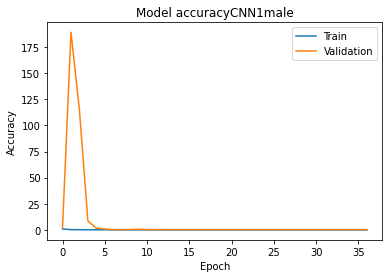

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy'+notebookname)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()